<a href="https://colab.research.google.com/github/Robin970822/DABC-Net-for-COVID-19/blob/master/DABC_pipeline_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Before We Start

**1. Download code from github.**

```bash
git clone https://github.com/Robin970822/DABC-Net-for-COVID-19.git
```

**2. Change directories to DABC-Net-for-COVID-19.**

```bash
cd DABC-Net-for-COVID-19
```

Mind that this shared folder DABC-Net-for-COVID-19 might be seen or modified by other users. Your other data and files on google drive are safe and independent. 

**3. Download data and model weights with download.sh.**

```bash
sh download.sh
```

**4. Set your Hardware accelerator as GPU in Edit/Notebook settings in Colab Menu.**

**5. Make sure your folder structure is corret.**

The folder structure looks like this:
```bash
path
├─Input_data
│      2020034797_0123_2949_20200123015940_4.nii.gz
│      2020034797_0125_3052_20200125111145_4.nii.gz
│      ...
│
├─Output_data
│   │
│   ├─covid
│   │      2020034797_0123_2949_20200123015940_4.nii.gz
│   │      2020034797_0125_3052_20200125111145_4.nii.gz
│   │      ...
│   │
│   ├─lung
│   │      2020034797_0123_2949_20200123015940_4.nii.gz
│   │      2020034797_0125_3052_20200125111145_4.nii.gz
│   │      ...
│   │
│   └─uncertainty
│           2020034797_0123_2949_20200123015940_4_predictive_aleatoric.nii.gz
│           2020034797_0125_3052_20200125111145_4_sample_1.nii.gz
│           ...
│
├─weight
│       model_05090017
│       ...
│
│ (following folders are required if you need longitudinal study)
│
├─meta
│       2020035021.csv
│
└─model
        prediction.pkl
        ...
```



# Step I: 
## Setup environment and load data.

Make sure you have set **GPU** acceleration when you run this notebook. See your Hardware accelerator in Edit/Notebook settings in Colab Menu(On the upper left usually).

## Pull code from github

In [1]:
!git clone https://github.com/Robin970822/DABC-Net-for-COVID-19.git

Cloning into 'DABC-Net-for-COVID-19'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 409 (delta 162), reused 162 (delta 77), pack-reused 146
Receiving objects: 100% (409/409), 6.65 MiB | 25.51 MiB/s, done.
Resolving deltas: 100% (229/229), done.


In [2]:
cd /content/DABC-Net-for-COVID-19/

/content/DABC-Net-for-COVID-19


In [3]:
!git pull origin master

From https://github.com/Robin970822/DABC-Net-for-COVID-19
 * branch            master     -> FETCH_HEAD
Already up to date.


## Download data and model weights

It will take 3 mintues.

In [4]:
!sh download.sh

Downloading...
From: https://drive.google.com/uc?id=1g3Hi_utRCV_c2J6B-QA0sMEM4x8FT_Cx
To: /content/DABC-Net-for-COVID-19/2020035365/2020035365.zip
1.11GB [00:08, 127MB/s]
Archive:  2020035365.zip
  inflating: 2020035365_0204_3050_20200204184413_4.nii.gz  
  inflating: 2020035365_0207_3052_20200207110908_4.nii.gz  
  inflating: 2020035365_0209_3052_20200209161622_4.nii.gz  
  inflating: 2020035365_0212_Lung_Screening_20200212101052_203.nii.gz  
  inflating: 2020035365_0215_Lung_Screening_20200215100533_203.nii.gz  
  inflating: 2020035365_0218_Lung_Screening_20200218091424_203.nii.gz  
  inflating: 2020035365_0304_Chest_Thorax_20200304110557_4.nii.gz  
  inflating: 2020035365_0320_Chest_Thorax_20200320101254_4.nii.gz  
Downloading...
From: https://drive.google.com/uc?id=1u3womSiXn0cmlkMQLikUAcHj28lud4_t
To: /content/DABC-Net-for-COVID-19/2020035021/2020035021.zip
917MB [00:13, 69.6MB/s]
Archive:  2020035021.zip
  inflating: 2020035021_1_3050_20200129200802_4.nii.gz  
  inflating: 202003

Make sure you are in DABC-Net-for-COVID-19

In [5]:
pwd

'/content/DABC-Net-for-COVID-19'

## Set up environment and install all necessary packages

Make sure you have set **GPU** acceleration when you run this notebook. See your Hardware accelerator in **Edit/Notebook settings** in Colab Menu(On the upper left usually).

Note that you only use **xgboost==1.1.0** and **scikit-learn==0.21.3** to load the prediction model when you only need to run prediction and you can also skip inference steps.

In [ ]:
pip install SimpleITK tensorflow-gpu==1.15.4 keras==2.2.4 xgboost==1.1.0 scikit-learn==0.21.3 scipy==1.1

# Step II:
## Lung and lesion Segmentation.

## Load datasets and pretrained model

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from models import models as Model
from pipeline.inference_pipeline import local_inference
from pipeline.data_pipeline import save_pred_to_nii, read_from_nii, confirm_data

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


def DABC_infer(nii_path='', save_path='', usage='covid'):
    save_path = save_path + '/*'
    nii_path = nii_path + '/*'
    all_src_data = read_from_nii(nii_path=nii_path, Hu_window=(-1024, 512), need_rotate=True)
    all_src_data = np.expand_dims(all_src_data, -1)

    print('\n**********\tInferring CT scans:\t**********\n')
    test_vol = confirm_data(all_src_data)
    '''
    infer
    '''
    if usage == 'covid':
        name = 'weight/Covid_05112327'
    elif usage == 'lung':
        name = 'weight/model_05090017'
    else:
        print('Please select correct model!')
        return None
    model = Model.DABC(input_size=(4, 256, 256, 1), load_weighted=name)
    pred = local_inference(test_vol, model)
    save_pred_to_nii(pred=pred, save_path=save_path.replace('*', ''), ref_path=nii_path,
                     need_resize=True, need_rotate=True)

Using TensorFlow backend.


## Run lung and lesion segmentation
It takes about 8 minutes for lesion segmentation of 8 input CT scans.

In [ ]:
# Segment lesion
input_path='2020035365'
output_path='2020035365_output/covid'
DABC_infer(input_path, output_path)

Finding  8  nii.gz format files.	
Reading:	 2020035365_0204_3050_20200204184413_4.nii.gz
(396, 512, 512)
Reading:	 2020035365_0207_3052_20200207110908_4.nii.gz
(468, 512, 512)
Reading:	 2020035365_0209_3052_20200209161622_4.nii.gz
(468, 512, 512)
Reading:	 2020035365_0212_Lung_Screening_20200212101052_203.nii.gz
(373, 512, 512)
Reading:	 2020035365_0215_Lung_Screening_20200215100533_203.nii.gz
(376, 512, 512)
Reading:	 2020035365_0218_Lung_Screening_20200218091424_203.nii.gz
(375, 512, 512)
Reading:	 2020035365_0304_Chest_Thorax_20200304110557_4.nii.gz
(363, 512, 512)
Reading:	 2020035365_0320_Chest_Thorax_20200320101254_4.nii.gz
(382, 512, 512)
Done.

**********	Inferring CT scans:	**********

Dataset loaded
800/800 [==============================] - 113s 141ms/step

**********	 8 file(s) to save: 	**********

Saving:	 (396, 512, 512)
Saving:	 (468, 512, 512)
Saving:	 (468, 512, 512)
Saving:	 (373, 512, 512)
Saving:	 (376, 512, 512)
Saving:	 (375, 512, 512)
Saving:	 (363, 512, 512)
Sa

It takes about 8 minutes for lung segmentation of 8 input CT scans.

In [ ]:
# Segment lung
output_path='2020035365_output/lung'
DABC_infer(input_path, output_path, usage='lung')

Finding  8  nii.gz format files.	
Reading:	 2020035365_0204_3050_20200204184413_4.nii.gz
(396, 512, 512)
Reading:	 2020035365_0207_3052_20200207110908_4.nii.gz
(468, 512, 512)
Reading:	 2020035365_0209_3052_20200209161622_4.nii.gz
(468, 512, 512)
Reading:	 2020035365_0212_Lung_Screening_20200212101052_203.nii.gz
(373, 512, 512)
Reading:	 2020035365_0215_Lung_Screening_20200215100533_203.nii.gz
(376, 512, 512)
Reading:	 2020035365_0218_Lung_Screening_20200218091424_203.nii.gz
(375, 512, 512)
Reading:	 2020035365_0304_Chest_Thorax_20200304110557_4.nii.gz
(363, 512, 512)
Reading:	 2020035365_0320_Chest_Thorax_20200320101254_4.nii.gz
(382, 512, 512)
Done.

**********	Inferring CT scans:	**********

Dataset loaded
800/800 [==============================] - 105s 132ms/step

**********	 8 file(s) to save: 	**********

Saving:	 (396, 512, 512)
Saving:	 (468, 512, 512)
Saving:	 (468, 512, 512)
Saving:	 (373, 512, 512)
Saving:	 (376, 512, 512)
Saving:	 (375, 512, 512)
Saving:	 (363, 512, 512)
Sa

Postprocessing as refinement: remove small segmented area to reduce falsepositive region

(This step is optional)

In [ ]:
# from postprocess_lung import remove_small_objects
# remove_small_objects('2020035365_output/lung')

# Step III:
## Infer segmentation uncertainty through monte-carlo dropout

It will take about 2 minutes for 5 monte-carlo samples

In [ ]:
from DABC_uncertainty_colab import DABC_uncertainty
# run 5x inference
DABC_uncertainty('2020035365/2020035365_0204_3050_20200204184413_4.nii.gz', '2020035365_output/uncertainty', sample_value=5, uc_chosen='Both')

Finding  1  nii.gz format files.	
Reading:	 2020035365_0204_3050_20200204184413_4.nii.gz
(396, 512, 512)
Done.

**********	Inferring CT scans:	**********

Dataset loaded
99/99 [==============================] - 17s 169ms/step
Dataset loaded
99/99 [==============================] - 14s 140ms/step
Dataset loaded
99/99 [==============================] - 14s 140ms/step
Dataset loaded
99/99 [==============================] - 14s 141ms/step
Dataset loaded
99/99 [==============================] - 14s 141ms/step

**********	 1 file(s) to save: 	**********

Saving:	 (396, 512, 512)
Done.

**********	 1 file(s) to save: 	**********

Saving:	 (396, 512, 512)
Done.


# Step IV: 

## Visualisation of segmentation results, uncertainties and progress curve

## Plot segmentation

In [ ]:
import pandas as pd
from utils.visualization import data_disease_slice, plot_segmentation, plot_progress_curve, plot_uncertainty
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Severe patient
raw_severe, lung_severe, lesion_severe, ratio_severe = data_disease_slice(patientID='2020035365', slice_id=[175, 162, 195, 195, 195, 195, 195, 195])

meta_path='meta/2020035365.csv'
meta = pd.read_csv(meta_path, index_col=[0])
_meta_severe = meta[meta['slice'] > 100]
_meta_severe['ratio'] = ratio_severe

In [ ]:
# Mild patient
# To avoid waiting, the segmentation results of mild patient have already run and saved in 2020035021_output/ folder.
# If you want to reqeat the results, please change the patientID from 2020035365 to 2020035021 in inference steps.

raw_mild, lung_mild, lesion_mild, ratio_mild = data_disease_slice(patientID='2020035021', slice_id=[200, 200, 200, 200, 200, 200])

meta_path='meta/2020035021.csv'
meta = pd.read_csv(meta_path, index_col=[0])
_meta_mild = meta[meta['slice'] > 100]
_meta_mild['ratio'] = ratio_mild

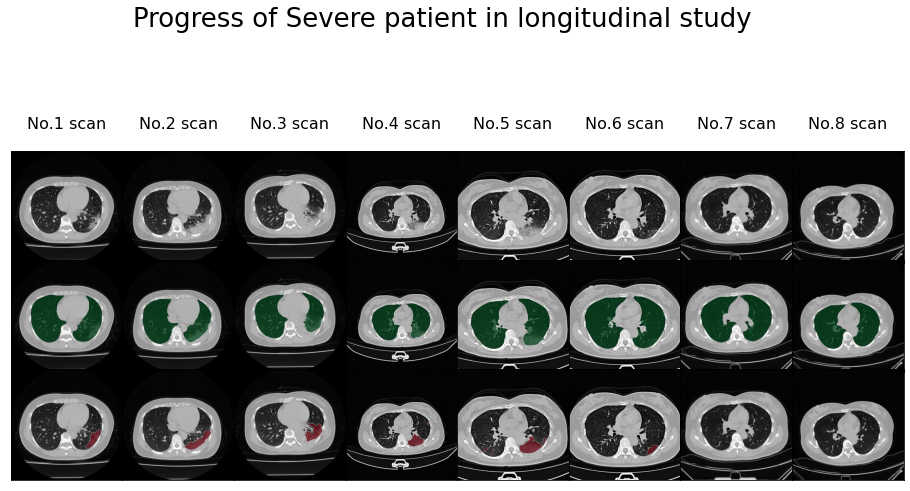

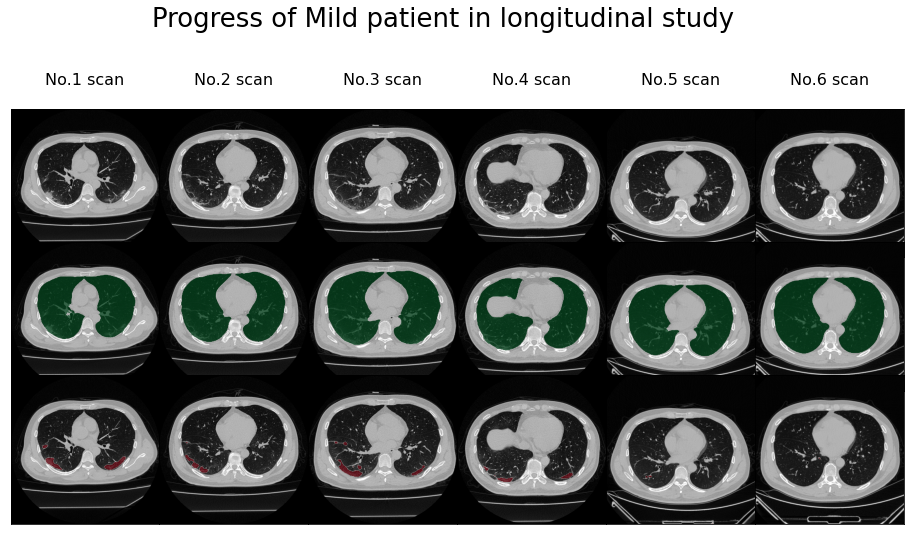

In [ ]:
plot_segmentation(raw_severe, lung_severe, lesion_severe, color_map='Reds', state='Severe', hspace=-0.6)

plot_segmentation(raw_mild, lung_mild, lesion_mild, color_map='Reds', state='Mild', hspace=-0.4)


## Plot progress curve

Text(0, 0.5, 'Lesion ratio')

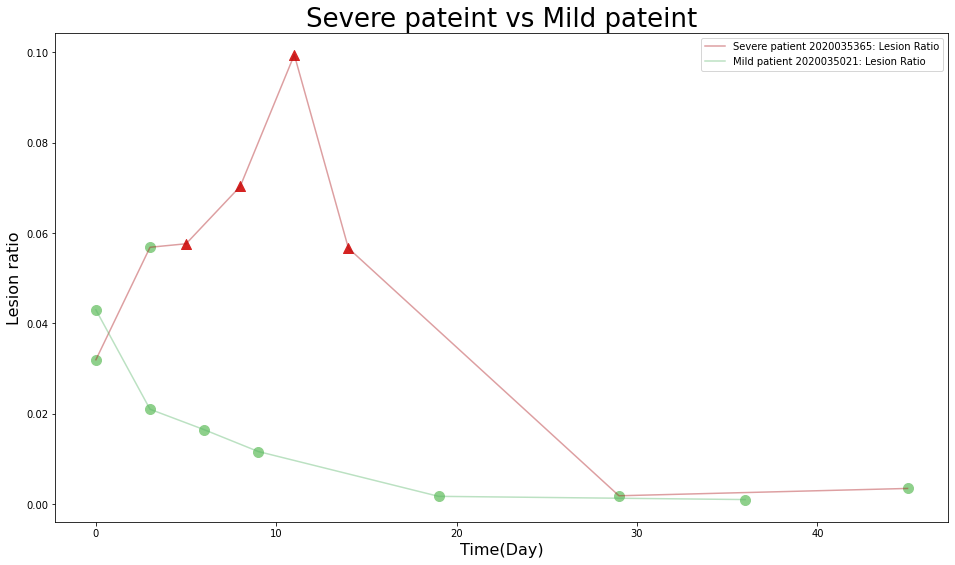

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plot_progress_curve(_meta_severe, patientID=2020035365, line_color=sns.color_palette('Reds')[5], label='Severe patient')
plot_progress_curve(_meta_mild, patientID=2020035021, line_color=sns.color_palette('Greens')[3], label='Mild patient')
plt.legend(loc='upper right')
plt.title('Severe pateint vs Mild pateint', fontsize=26)
plt.xlabel('Time(Day)', fontsize=16)
plt.ylabel('Lesion ratio', fontsize=16)

## Plot uncertainty


Slice: 175/396


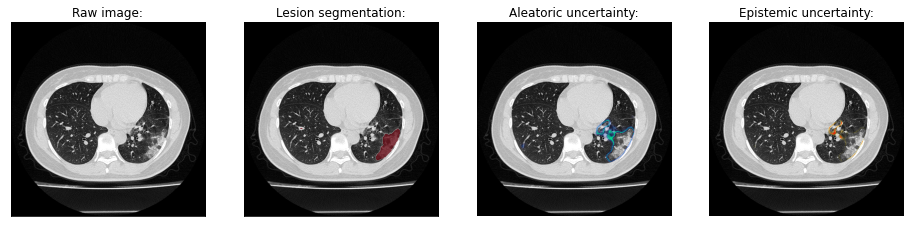

In [ ]:
# Example I:
plot_uncertainty(name_id='2020035365_0204_3050_20200204184413_4.nii.gz',slice_id=175)

Slice: 150/396


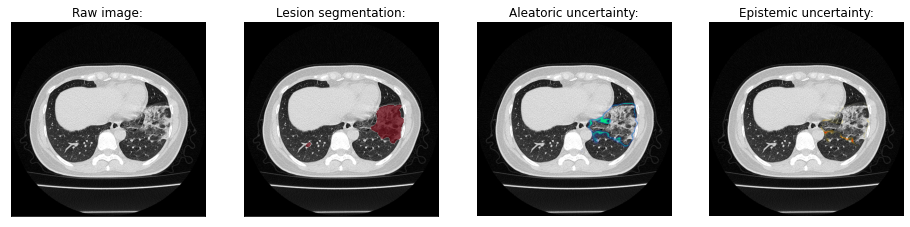

In [ ]:
# Example II:
plot_uncertainty(name_id='2020035365_0204_3050_20200204184413_4.nii.gz',slice_id=150)

#Step V:
## Prediction of penumonia progression 

## Load data
  In this section, we present one mild patient and one severe patient with multi-scans to show progress of the disease and illustrate our model performance.

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.calculate_feature import *
from utils.visualization import *
from pipeline.data_pipeline import read_from_nii

In [9]:
# severe patient
meta_path_severe='meta/2020035365.csv'
meta_severe = pd.read_csv(meta_path_severe, index_col=[0])

raw_data_severe = read_from_nii('2020035365/*').astype('float32')
lung_severe = read_from_nii(r'2020035365_output/lung/*').astype('float32')
lesion_severe = read_from_nii(r'2020035365_output/covid/*').astype('float32')

# mild patient
meta_path_mild='meta/2020035021.csv'
meta_mild = pd.read_csv(meta_path_mild, index_col=[0])

Finding  8  nii.gz format files.	
Reading:	 2020035365_0204_3050_20200204184413_4.nii.gz
(396, 512, 512)
Reading:	 2020035365_0207_3052_20200207110908_4.nii.gz
(468, 512, 512)
Reading:	 2020035365_0209_3052_20200209161622_4.nii.gz
(468, 512, 512)
Reading:	 2020035365_0212_Lung_Screening_20200212101052_203.nii.gz
(373, 512, 512)
Reading:	 2020035365_0215_Lung_Screening_20200215100533_203.nii.gz
(376, 512, 512)
Reading:	 2020035365_0218_Lung_Screening_20200218091424_203.nii.gz
(375, 512, 512)
Reading:	 2020035365_0304_Chest_Thorax_20200304110557_4.nii.gz
(363, 512, 512)
Reading:	 2020035365_0320_Chest_Thorax_20200320101254_4.nii.gz
(382, 512, 512)
Done.
Finding  8  nii.gz format files.	
Reading:	 2020035365_0204_3050_20200204184413_4.nii.gz
(396, 512, 512)
Reading:	 2020035365_0207_3052_20200207110908_4.nii.gz
(468, 512, 512)
Reading:	 2020035365_0209_3052_20200209161622_4.nii.gz
(468, 512, 512)
Reading:	 2020035365_0212_Lung_Screening_20200212101052_203.nii.gz
(373, 512, 512)
Reading:	 

In [10]:
def predict_base_learners(base_learners, x):
    P = np.zeros((x.shape[0], len(base_learners)))
    print('Generating base learner predictions.')
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        p = m.predict_proba(x)
        P[:, i] = p[:, 1]
    print('done.')
    return P


## Calculate all 14 features from the segmenetion results


In [11]:
res_list_severe, all_info_severe = calculate(raw_data_severe, lung_severe, lesion_severe, meta_severe)

del raw_data_severe, lung_severe, lesion_severe  # release RAM

# mild patient
raw_data_mild = read_from_nii(r'2020035021/*').astype('float32')
lung_mild = read_from_nii(r'2020035021_output/lung/*').astype('float32')
lesion_mild = read_from_nii(r'2020035021_output/covid/*').astype('float32')

res_list_mild, all_info_mild = calculate(raw_data_mild, lung_mild, lesion_mild, meta_mild)
del raw_data_mild, lung_mild, lesion_mild

Finding  6  nii.gz format files.	
Reading:	 2020035021_1_3050_20200129200802_4.nii.gz
(396, 512, 512)
Reading:	 2020035021_2_3051_20200201093438_4.nii.gz
(468, 512, 512)
Reading:	 2020035021_3_3051_20200204112947_4.nii.gz
(468, 512, 512)
Reading:	 2020035021_4_3051_20200207130347_4.nii.gz
(560, 512, 512)
Reading:	 2020035021_5_Chest_Thorax_20200217105636_4.nii.gz
(426, 512, 512)
Reading:	 2020035021_6_Chest_Thorax_20200305105754_4.nii.gz
(469, 512, 512)
Done.
Finding  6  nii.gz format files.	
Reading:	 2020035021_1_3050_20200129200802_4.nii.gz
(396, 512, 512)
Reading:	 2020035021_2_3051_20200201093438_4.nii.gz
(468, 512, 512)
Reading:	 2020035021_3_3051_20200204112947_4.nii.gz
(468, 512, 512)
Reading:	 2020035021_4_3051_20200207130347_4.nii.gz
(560, 512, 512)
Reading:	 2020035021_5_Chest_Thorax_20200217105636_4.nii.gz
(426, 512, 512)
Reading:	 2020035021_6_Chest_Thorax_20200305105754_4.nii.gz
(469, 512, 512)
Done.
Finding  6  nii.gz format files.	
Reading:	 2020035021_1_3050_2020012920

All features and infomation of Severe and Mild patient as shown below.

(You can also print the variable 'all_info_severe' or 'all_info_mild' directly in new blank code cell.)

In [41]:
from utils.visualization import plot_fetures

plot_fetures(all_info_severe=all_info_severe, all_info_mild=all_info_mild, save_to_html=True)  # x-axis:time(day), y-axis: lesion ratio

Animation of progress curve

In [20]:
from utils.visualization import plot_animation_curve

plot_animation_curve(all_info=all_info_severe)  # x-axis:time(day), y-axis: lesion ratio

## Prediction
### Load model

In [ ]:
import pickle
import json

with open('model/prediction.pkl', 'rb') as j:
    base_pred = pickle.load(j)

with open('model/min_max_prediction.json', 'r') as j:
    min_max_dict_pred = json.load(j)

with open('model/classification.pkl', 'rb') as j:
    base_cls = pickle.load(j)

with open('model/min_max_classification.json', 'r') as j:
    min_max_dict_cls = json.load(j)

feature = [
    'left_ratio', 'right_ratio',
    'left_lung', 'right_lung',
    'left_lesion', 'right_lesion',

    'left_weighted_lesion', 'right_weighted_lesion',

    'left_consolidation', 'right_consolidation',

    'left_z', 'right_z',
    'Age', 'sex',
]

## Preprocessing

In [ ]:
X_severe = preprocessing(all_info_severe, feature)
X_mild = preprocessing(all_info_mild, feature)

## Per Scan Classification for different timepoint.

In [ ]:
def Per_Scan_Classification(X):
  x = min_max_scalar(np.array(X), np.array(min_max_dict_cls['min']), np.array(min_max_dict_cls['max']))
  P_pred = predict_base_learners(base_cls, np.array(x))
  p = P_pred.mean(axis=1)
  return p

p_severe = Per_Scan_Classification(X_severe)
print('Prediction of severe patient(per scan):\n{}\n'.format(p_severe))
p_mild = Per_Scan_Classification(X_mild)
print('Prediction of mild patient(per scan):\n{}\n'.format(p_mild))

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
Prediction of severe patient(per scan):
[0.14053141 0.58620075 0.5035697  0.60239658 0.60940856 0.25515419
 0.04229041 0.06513349]

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
Prediction of mild patient(per scan):
[0.10512683 0.12899253 0.07386904 0.08071273 0.05081999 0.02229139]



In [ ]:
print('\n'+'*'*10+'\tSevere patient\t'+'*'*10)
print('pred\t{} \ngt\t{} \nprob {}'.format((p_severe > 0.5).astype('int'), np.array(all_info_severe['Severe']), p_severe))
print('\n'+'*'*10+'\tMild patient\t'+'*'*10)
print('pred\t{} \ngt\t{} \nprob {}'.format((p_mild > 0.5).astype('int'), np.array(all_info_mild['Severe']), p_mild))


**********	Severe patient	**********
pred	[0 1 1 1 1 0 0 0] 
gt	[0 0 1 1 1 1 0 0] 
prob [0.14053141 0.58620075 0.5035697  0.60239658 0.60940856 0.25515419
 0.04229041 0.06513349]

**********	Mild patient	**********
pred	[0 0 0 0 0 0] 
gt	[0 0 0 0 0 0] 
prob [0.10512683 0.12899253 0.07386904 0.08071273 0.05081999 0.02229139]


## First Two Scans

In [ ]:
def First_Two_Scans(X):
  # first two scan
  x_list = X.iloc[1].tolist()[:-2] + X.iloc[0].tolist()
  # min max scale
  x = min_max_scalar(np.array(x_list), np.array(min_max_dict_pred['min']), np.array(min_max_dict_pred['max']))

  # Predition
  P_pred = predict_base_learners(base_pred, np.array([x]))
  return P_pred.mean()

print('\n'+'*'*10+'\tSevere patient\t'+'*'*10)
print(First_Two_Scans(X_severe))
print('\n'+'*'*10+'\tMild patient\t'+'*'*10)
print(First_Two_Scans(X_mild))


**********	Severe patient	**********
Generating base learner predictions.
svm...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
0.8604198236305692

**********	Mild patient	**********
Generating base learner predictions.
svm...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
0.10213843493911157


## First Three Scans

In [ ]:
with open('model/prediction_first_3.pkl', 'rb') as j:
    base_pred = pickle.load(j)

with open('model/min_max_prediction_first_3.json', 'r') as j:
    min_max_dict_pred = json.load(j)


def First_Three_Scans(X):
  # first two scan
  x_list = X.iloc[2].tolist()[:-2] + X.iloc[1].tolist()
  # min max scale
  x = min_max_scalar(np.array(x_list), np.array(min_max_dict_pred['min']), np.array(min_max_dict_pred['max']))

  # Predition
  P_pred = predict_base_learners(base_pred, np.array([x]))
  return P_pred.mean()

print('\n'+'*'*10+'\tSevere patient\t'+'*'*10)
print(First_Three_Scans(X_severe))
print('\n'+'*'*10+'\tMild patient\t'+'*'*10)
print(First_Three_Scans(X_mild))


**********	Severe patient	**********
Generating base learner predictions.
svm...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
0.9303948488255498

**********	Mild patient	**********
Generating base learner predictions.
svm...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
0.029796939897368965


## First Scan
Using first scan to predict progress.

Note: only use first scan is not reliable, we recomand using first two or three scans to predict disease progression.
(In this section, the severe patient progress prediction is wrong using first scan. However, when use two or three scan, model can predict correctly with high confidence)

In [ ]:
from copy import deepcopy
with open('model/prediction_first.pkl', 'rb') as j:
    base_pred = pickle.load(j)

with open('model/min_max_prediction_first.json', 'r') as j:
    min_max_dict_pred = json.load(j)


def First_Scan(X):
  # first two scan
  x_list = X.iloc[0].tolist()
  # min max scale
  x = min_max_scalar(np.array(x_list), np.array(min_max_dict_pred['min']), np.array(min_max_dict_pred['max']))

  # Predition
  P_pred = predict_base_learners(base_pred, np.array([x]))
  return P_pred.mean()

print('\n'+'*'*10+'\tSevere patient\t'+'*'*10)
print(First_Scan(deepcopy(X_severe)))
print('\n'+'*'*10+'\tMild patient\t'+'*'*10)
print(First_Scan(deepcopy(X_mild)))


**********	Severe patient	**********
Generating base learner predictions.
svm...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
0.6459909133275394

**********	Mild patient	**********
Generating base learner predictions.
svm...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
0.689006938166566


## Progress of disease

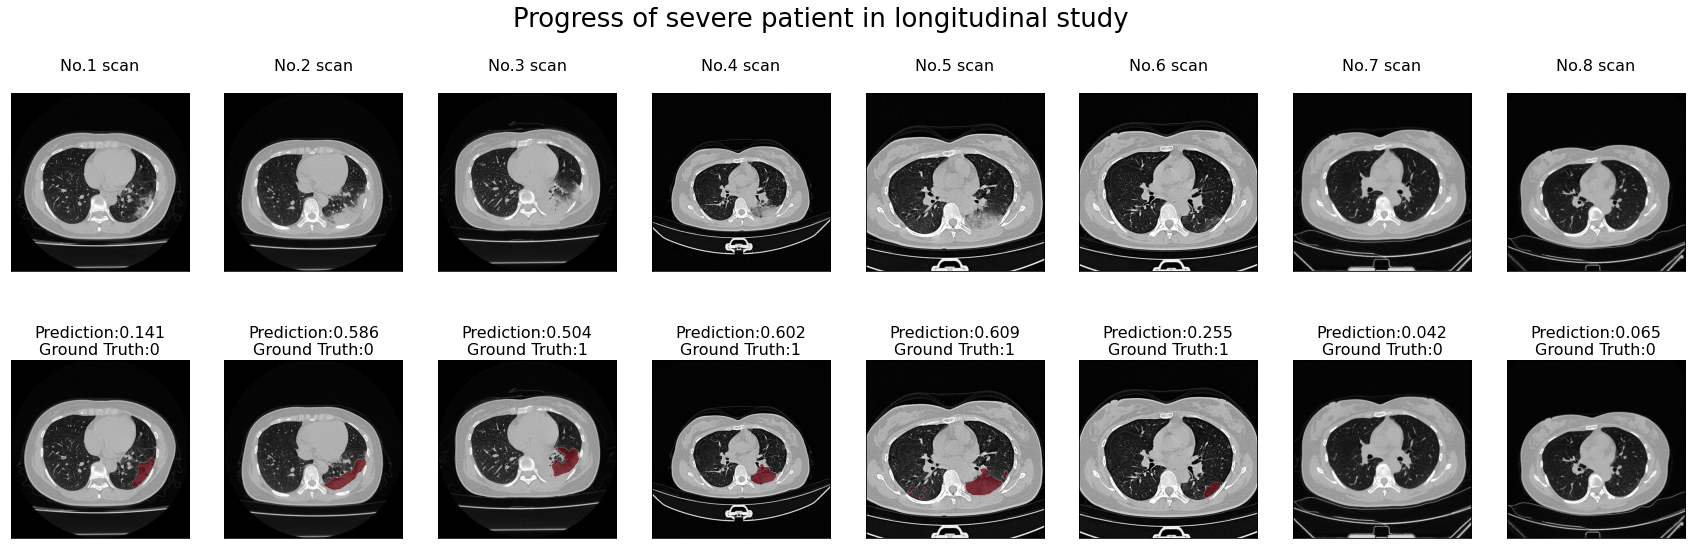

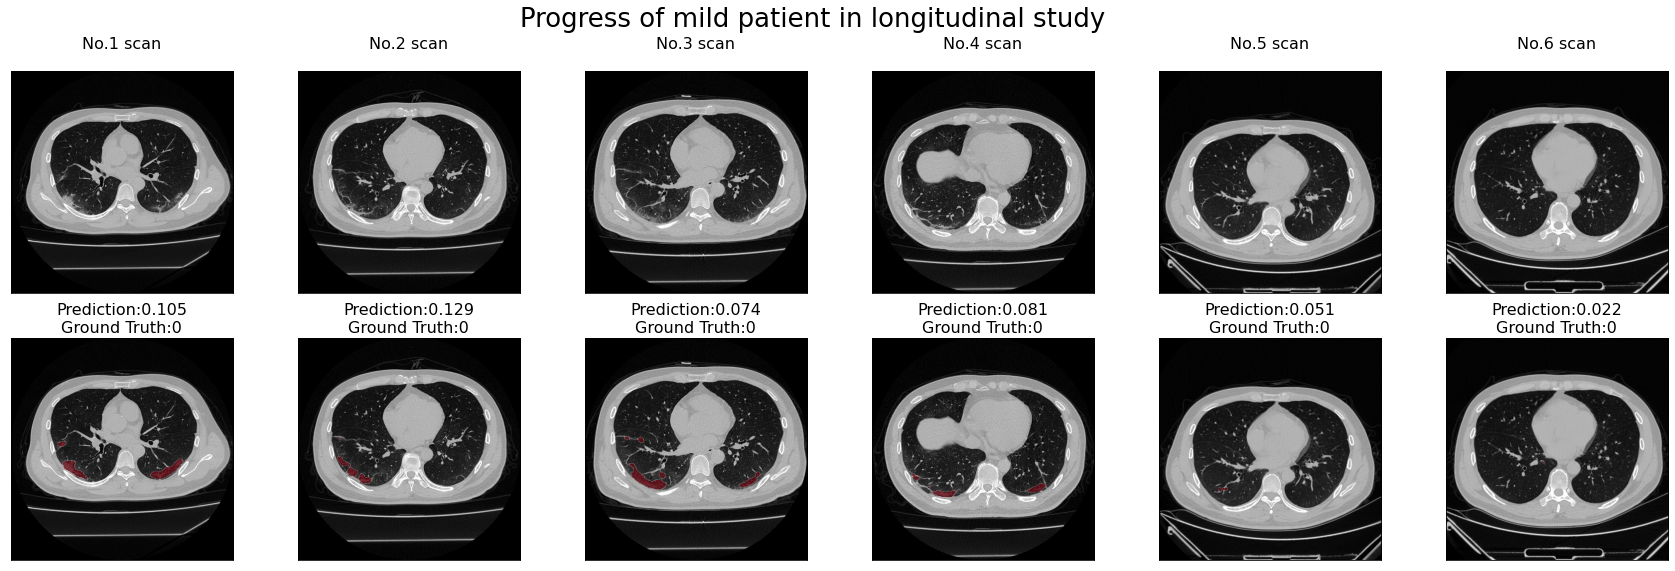

In [ ]:
slice_id = [175, 162, 195, 195, 195, 195, 195, 195]
raw, lesion, gt = data_disease_progress_slice(all_info_severe, patientID=2020035365, slice_id=slice_id, timepoint_count=8)
plot_progress(raw, lesion, p_severe, gt, state='severe', color_map='Reds', timepoint_count=8)

print('\n\n')
slice_id = [200, 200, 200, 200, 200, 200]
raw, lesion, gt = data_disease_progress_slice(all_info_mild, patientID=2020035021, slice_id=slice_id, timepoint_count=6)
plot_progress(raw, lesion, p_mild, gt, state='mild', color_map='Reds', timepoint_count=6)

<center>Predict the patient situation in the progression of disease using per CT scan.</center>